# Financial Big Data - Final Project

***Authors: Michael Allemann, Roman Bachmann***

***16.01.2019***

This is the Jupyter Notebook of our final project in the course FIN-525 Financial Big Data.
Here we conduct the data preprocessing, show stylized facts of our data and run our predictive model on it.
Many parts of the code that are used multiple times can be found in the folder ```project_lib```.

In [11]:
import os
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from project_lib.preprocessing import preprocess
from project_lib.plotting import plot_1ecdf, plot_losses, plot_cumsums
from project_lib.dataset import StockDataSet
from project_lib.models import LSTM_Model
from project_lib.utils import predict_stock, plot_rolling_window, evaluate

%matplotlib inline

In [12]:
# Device agnostic PyTorch setup
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
    torch.backends.cudnn.enabled = True
else:
    device = torch.device('cpu')
    torch.backends.cudnn.enabled = False

## 1 Data preprocessing

In [13]:
CWD = os.getcwd()
DATA_RAW_DIR = os.path.join(CWD, 'data/Raw/')
DATA_CLEAN_DIR = os.path.join(CWD, 'data/Clean/')

### 1.1 Cleaning data and computing log-returns

**Warning:** The following cells take a long time (1+ hours) to run. To load cleaned data, skip to section 1.2.

We load the stocks ABBN, CSGN, NESN and NOVN from the provided compressed intra-day files. To run the below code, place the Raw data folder under ```./data/Raw/<stock_name>/```.

From the raw files we compute the average best offer as $\frac{bid + ask}{2}$. We correctly set the time zone and resample such that we have five hourly data points from 11:00 to 15:00 every day. From this we then calculate log-returns.

In [ ]:
stocks_s = ['ABBN.S', 'CSGN.S', 'NESN.S', 'NOVN.S']
cleaned_df_s = preprocess(stocks_s, DATA_RAW_DIR, verbosity=1)

In [ ]:
stocks_vx = ['ABBN.VX', 'CSGN.VX', 'NESN.VX', 'NOVN.VX']
cleaned_df_vx = preprocess(stocks_vx, DATA_RAW_DIR, verbosity=1)

In [11]:
# Saving ABBN.S, CSGN.S, NESN.S, NOVN.S (ACNN S) as compressed CSV
cleaned_df_s.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_s.csv.gz'), compression='gzip')

# Saving ABBN.VX, CSGN.VX, NESN.VX, NOVN.VX (ACNN VX) as compressed CSV
cleaned_df_vx.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_vx.csv.gz'), compression='gzip')

In [18]:
stocks = ['ABBN', 'CSGN', 'NESN', 'NOVN']
cleaned_df_s.columns = stocks
cleaned_df_vx.columns = stocks

The full log-returns dataframe is the concatenation of both \*.S and \*.VX dataframes.

In [87]:
cleaned_df = pd.concat([cleaned_df_vx, cleaned_df_s])

# Saving ABBN, CSGN, NESN, NOVN (ACNN) as compressed CSV
cleaned_df.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip')

### 1.2 Loading the cleaned data and computing signs

In [14]:
# Loading the cleaned dataset
cleaned_df = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'acnn.csv.gz'), compression='gzip', 
                         index_col='datetime', parse_dates=True)

We would like to investigate how much information is still contained in the sign of the log-returns.

In [15]:
df_sign = np.sign(cleaned_df.dropna())

We observed that some days have some missing hours. We will remove them.

In [16]:
missing_hours_per_day = 5 - df_sign.groupby(lambda x: x.date).apply(lambda x: len(x))
count, bins = np.histogram(missing_hours_per_day, bins=[0,1,2,3,4,5])

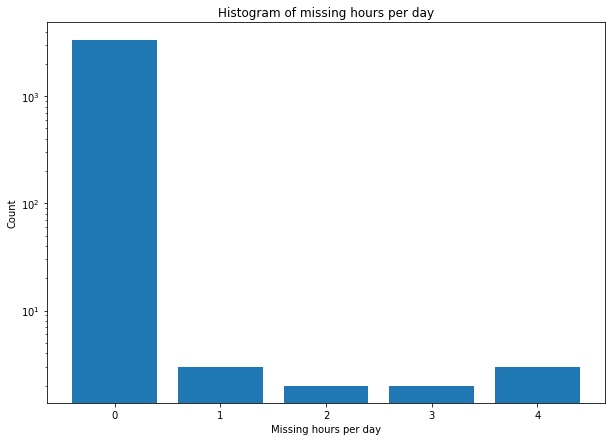

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(bins[:-1], count)
ax.set_yscale('log')
ax.set_xlabel('Missing hours per day')
ax.set_ylabel('Count')
ax.set_title('Histogram of missing hours per day')
plt.show()

In [18]:
missing_hours_per_day_df = pd.DataFrame(missing_hours_per_day)
missing_hours_per_day_df.index = pd.to_datetime(missing_hours_per_day_df.index)
missing_hours_per_day_df.columns = ['missing_hours']
missing_hours_per_day_df = missing_hours_per_day_df.resample('1H').pad()
df_sign_missing = df_sign.join(missing_hours_per_day_df,how='inner')

df_sign_missing = df_sign_missing[df_sign_missing.missing_hours == 0]

df_sign = df_sign_missing.drop('missing_hours', axis=1)

In [19]:
# Saving the sign dataframe as a compressed csv
df_sign.to_csv(os.path.join(DATA_CLEAN_DIR, 'acnn_sign.csv.gz'), compression='gzip')

## 2 Stylized facts

In this part, we check that our data is indeed financial data.
We show the log-returns, autocorrelation and see if our data has a heavy tail.

### 2.1 Log-returns $r_t$

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8505e0f28>,
      dtype=object)

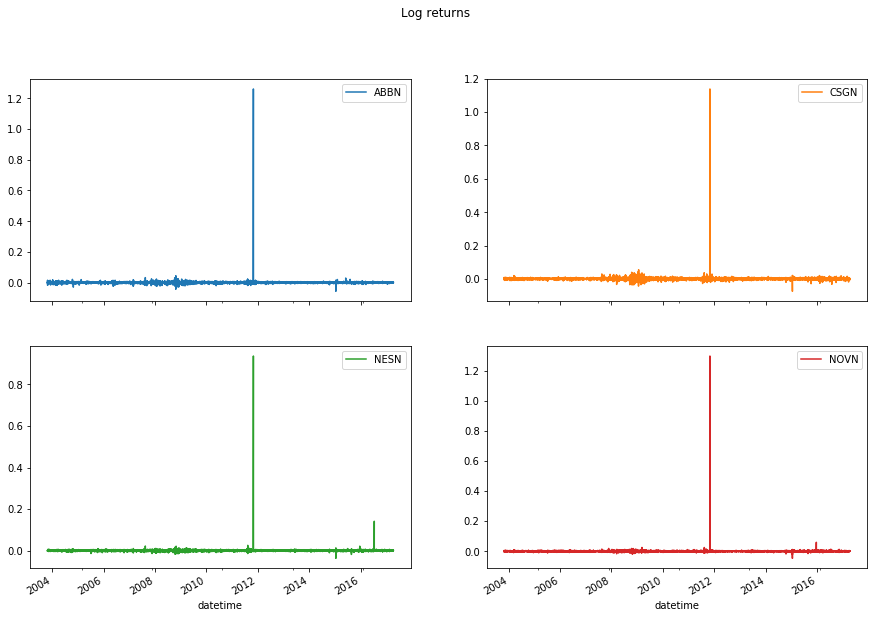

In [20]:
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')

There is one heavy outlier in late 2011. Just for this plot, we will remove it.
For the sign this outlier has no impact so we will not remove it from that.

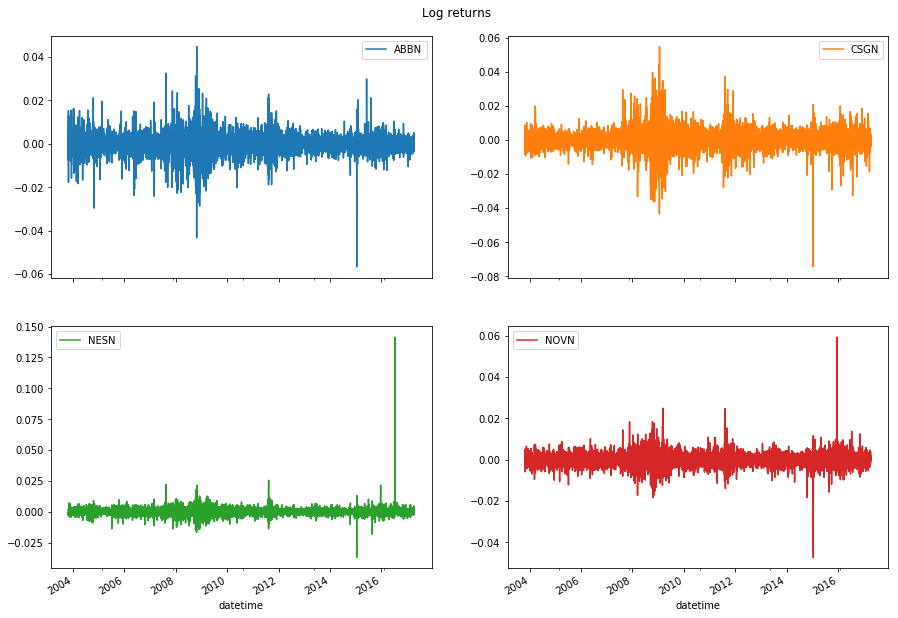

In [23]:
cleaned_df = cleaned_df[cleaned_df < 0.3].dropna()
cleaned_df.plot(subplots=True, layout=(2,2), figsize=(15,10), title='Log returns')
plt.subplots_adjust(top=0.94)
plt.savefig('./plots/log-returns.pdf', bbox_inches='tight')

### 2.2 Autocorrelation $C_r(\tau)$

If the dataset that we got is of financial nature, we expect it to have no autocorrelation.
As we see below, this is the case.

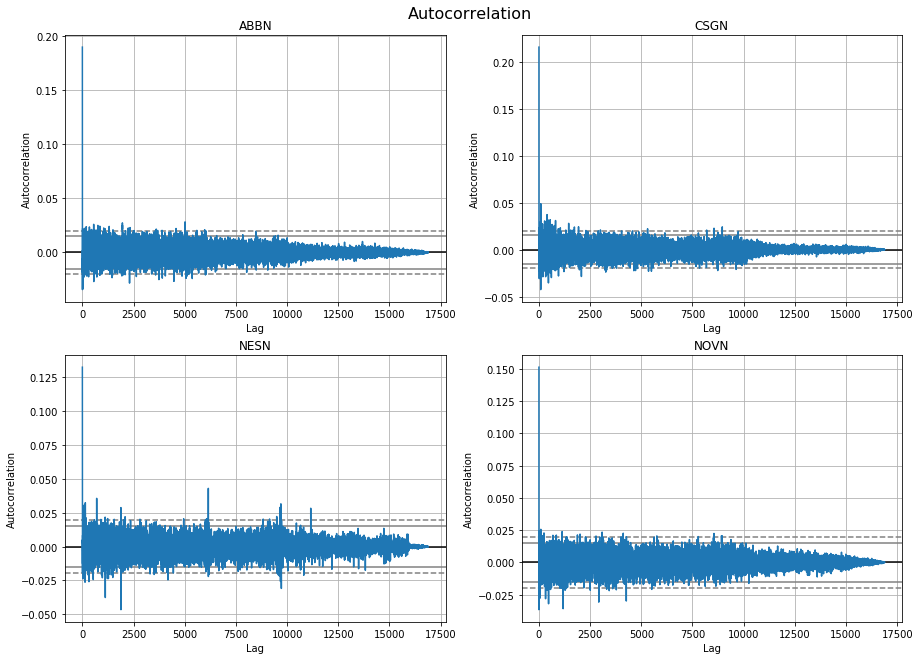

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.suptitle('Autocorrelation', fontsize=16)

pd.plotting.autocorrelation_plot(cleaned_df['ABBN'], ax=ax[0,0])
ax[0,0].set_title('ABBN')
pd.plotting.autocorrelation_plot(cleaned_df['CSGN'], ax=ax[0,1])
ax[0,1].set_title('CSGN')
pd.plotting.autocorrelation_plot(cleaned_df['NESN'], ax=ax[1,0])
ax[1,0].set_title('NESN')
pd.plotting.autocorrelation_plot(cleaned_df['NOVN'], ax=ax[1,1])
ax[1,1].set_title('NOVN')
fig.subplots_adjust(top=0.94)
fig.savefig('./plots/autocorrelation.pdf', bbox_inches='tight')

### 2.3 Plotting 1 minus ECDF

To check if our stocks' log-returns have a heavy tail, we plot 1 minus the empirical cumulative distribution function (ECDF) of the absolute log-returns.
The lin-log plots are difficult to interpret, but when plotting it on a log-log scale, we see the straight line on the right side, indicating that we are dealing with heavy tails.

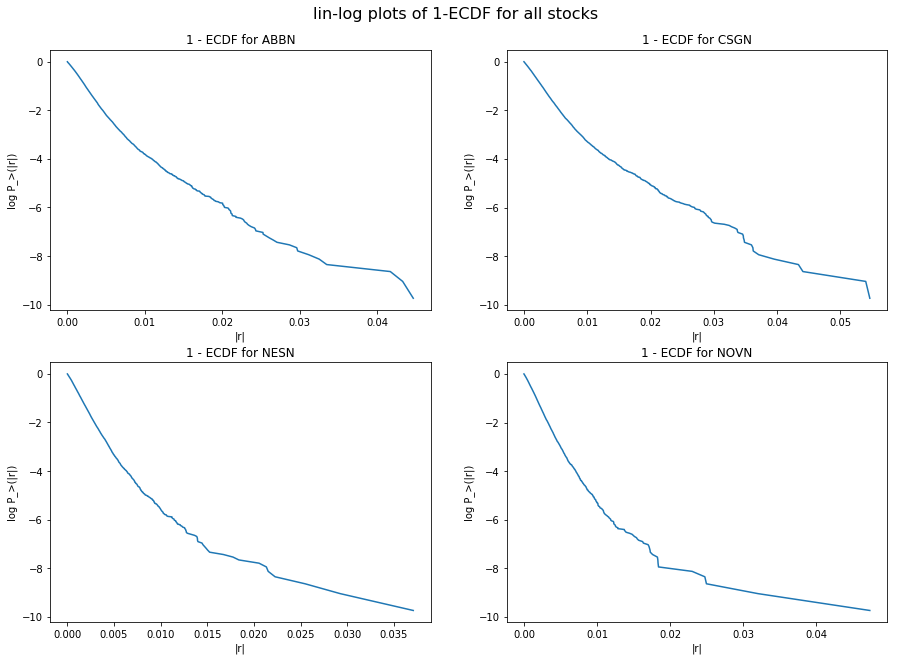

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plot_1ecdf(cleaned_df, 'ABBN', ax=ax[0,0], mode='lin-log')
plot_1ecdf(cleaned_df, 'CSGN', ax=ax[0,1], mode='lin-log')
plot_1ecdf(cleaned_df, 'NESN', ax=ax[1,0], mode='lin-log')
plot_1ecdf(cleaned_df, 'NOVN', ax=ax[1,1], mode='lin-log')
fig.suptitle('lin-log plots of 1-ECDF for all stocks', fontsize=16)
fig.subplots_adjust(top=0.92)
fig.savefig('./plots/1-ECDF-lin-log.pdf', bbox_inches='tight')

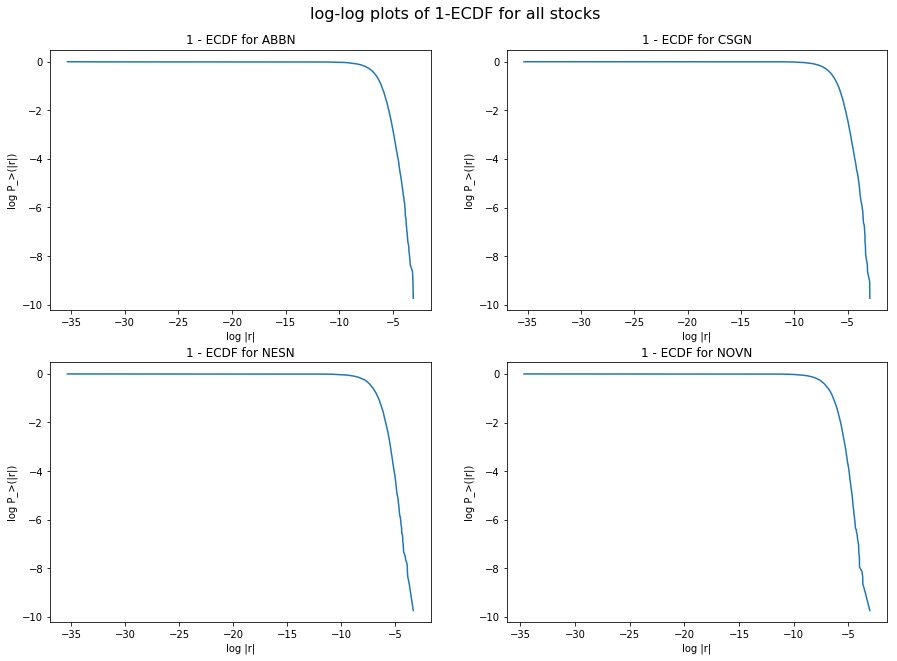

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plot_1ecdf(cleaned_df, 'ABBN', ax=ax[0,0], mode='log-log')
plot_1ecdf(cleaned_df, 'CSGN', ax=ax[0,1], mode='log-log')
plot_1ecdf(cleaned_df, 'NESN', ax=ax[1,0], mode='log-log')
plot_1ecdf(cleaned_df, 'NOVN', ax=ax[1,1], mode='log-log')
fig.suptitle('log-log plots of 1-ECDF for all stocks', fontsize=16)
fig.subplots_adjust(top=0.92)
fig.savefig('./plots/1-ECDF-log-log.pdf', bbox_inches='tight')

## 3 Forecasting Example

In this section we show the whole forecasting pipeline for one example period.
We train a LSTM network using data from the past 500 datapoints (100 business days), cut into 5 (business) day windows (25 data points).
From each window we train the network to predict the last data point using the 24 previous ones.
To generate our training data, we shift this window by one day at a time over the whole training period.
We do this for all four stocks and train the network on a random shuffle of all collected training samples.

### 3.1 Training the model

In [10]:
window_days = 5 # Number of days the LSTM sees at once
window_size = window_days * 5
step_size = 1 # Time shift for collecting training samples

start_date_train = pd.to_datetime('2013-04-05') # Example starting date
end_date_train = start_date_train + datetime.timedelta(days=150) # Example end date

To facilitate data loading, we create a data set containing all training inputs and outputs and feed it to a data loader giving us an efficient way of handing samples to the GPU.

In [11]:
batch_size = 32
train_dataset = StockDataSet(df_sign.loc[start_date_train:end_date_train], window_size=window_size, step_size=step_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)

Now we set up the LSTM model, the loss and optimizers and train it over 300 epochs, taking around 3 minutes.
The learning rate was chosen as big as possible to reduce training time, but as big that training would diverge.
A small weight decay (L2 regularizer parameter) was used to keep weights small.

In [12]:
model = LSTM_Model(1, hidden_size=64, num_layers=1)
criterion = torch.nn.MSELoss()
learning_rate = 5e-3
weight_decay = 1e-3 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [13]:
%%time

losses = []

num_epochs = 300
for epoch in range(num_epochs):
    if (epoch+1) % 50 == 0:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
    epoch_losses = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        hidden = model.init_hidden(batch_size)
        inputs = inputs.reshape(batch_size, window_size-1, 1).float().to(device)
        labels = labels.to(device)
        
        # Forward pass
        preds = model(inputs, hidden)

        loss = criterion(preds, labels.reshape(-1,1).float())
        epoch_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
    losses.append(np.array(epoch_losses).mean())

Epoch 50/300
Epoch 100/300
Epoch 150/300
Epoch 200/300
Epoch 250/300
Epoch 300/300
CPU times: user 1min 36s, sys: 1min 16s, total: 2min 52s
Wall time: 2min 55s


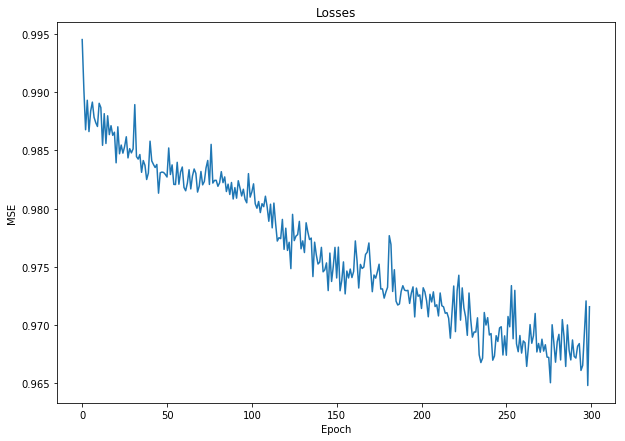

In [14]:
plot_losses(losses)

Experiments have shown that the loss does not decrease much further after 300 epochs. We stop it here to reduce overfitting and required computation time.

### 3.2 Prediction on test data

Prediction is done on the unseen test set starting right after the train set. 
We feed the network the first 5 days (24 data points) of the test set and predict the sign of the 25th point. 
This prediction is then appended to the known window and taken as input to the network.
We do this for 5 days into the future.

In [15]:
num_values_to_predict = 25
test_window = df_sign.loc[end_date_train:].iloc[:window_size-1+num_values_to_predict]

In [16]:
preds = []
for stock_name in ['ABBN', 'CSGN', 'NESN', 'NOVN']:
    preds.append(predict_stock(test_window, model, stock_name, 25, 25))
preds = pd.DataFrame(preds).transpose()

To be able to visualize our predictions nicely, we decided to compute the cumulative sum of our sign predictions.
Like that we can observe the trend in a cumulative fashion and compare it with the true data.

In [17]:
test_cumsum = test_window.join(preds).cumsum()
last_values = test_cumsum.iloc[window_size-2]
for stock_name in ['ABBN', 'CSGN', 'NESN', 'NOVN']:
    test_cumsum[stock_name + '_pred'] = test_cumsum[stock_name + '_pred'] + last_values[stock_name]

Text(0.5, 0.98, 'Cumulative sum of signs')

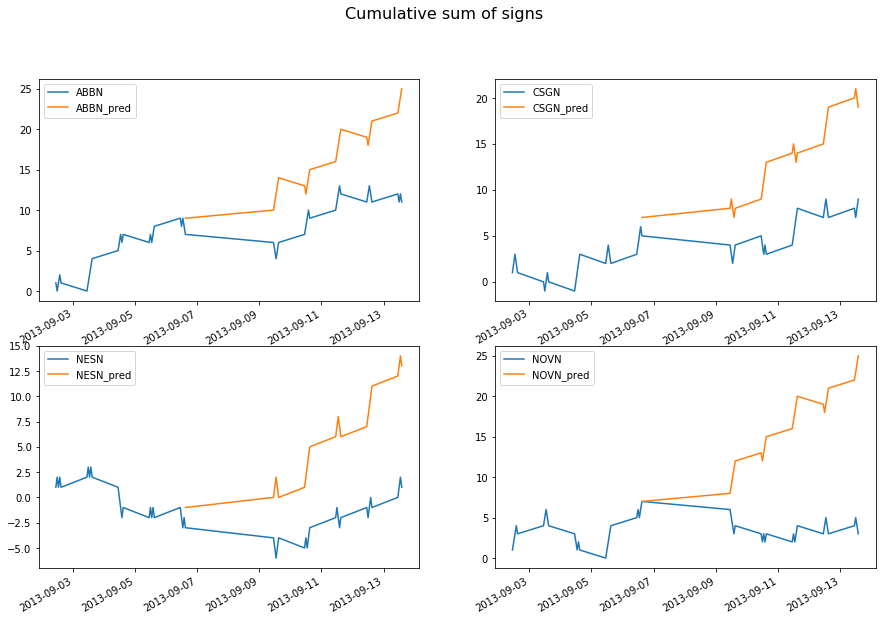

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
test_cumsum[['ABBN', 'ABBN_pred']].plot(ax=ax[0,0])
test_cumsum[['CSGN', 'CSGN_pred']].plot(ax=ax[0,1])
test_cumsum[['NESN', 'NESN_pred']].plot(ax=ax[1,0])
test_cumsum[['NOVN', 'NOVN_pred']].plot(ax=ax[1,1])
fig.suptitle('Cumulative sum of signs', fontsize=16)

In this plot we can get a hint on how the network behaves. After it has seen the 24 ground truth data points, it makes a prediction that the next day will go up or down.
When we append this prediction, the network gets reinforced by its previous prediction and is more likely to predict the same direction again.
Since we look 5 days or 25 data points into the future, the network only rarely straves into the opposite direction again, but then goes straight back to it.

## 4 Sliding window prediction

We would like to have a rolling window over the data. Our training window is always 100 business days, while the test window is 5 days for the initial data points plus 5 days that we predict.
We would always slide the window forward by 5 days and train again.

For one year we need to train a network floor((1245 - 500 - 25) / 25) = 28 times. 
From our previous section, we saw that training one window takes roughly 3 minutes on a Nvidia GTX 970 graphics card.
Training 28 times will take 28 * 3min = 84min.
Because with our dataset we have whole years from 2004 to 2013, we decided to train our method only on the evenly spaced years 2004, 2008, 2012 and 2016, which are all leap years, to reduce computing time.

For each sliding window, we trained on 500 datapoints, then feed the network the 24 next ones and try to predict the 25th one. 
We then take this prediction, add it to the previous 24 and cut off the first one after the training set.
This we feed again to the LSTM and record the output sign. We repeat this until we have collected 25 data points, or 5 business days.

To display the results of all sliding windows, we have decided to compute the cumulative sum of the ground truth log-return signs, starting from the first day where we are using unseen test data to predict (after 500 data points, in the beginning of June).
The cumulative prediction of each 5 day window is then overlayed at the point where the input 5 day window ends.

### 4.1 2004-2005

Total samples: 1245
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

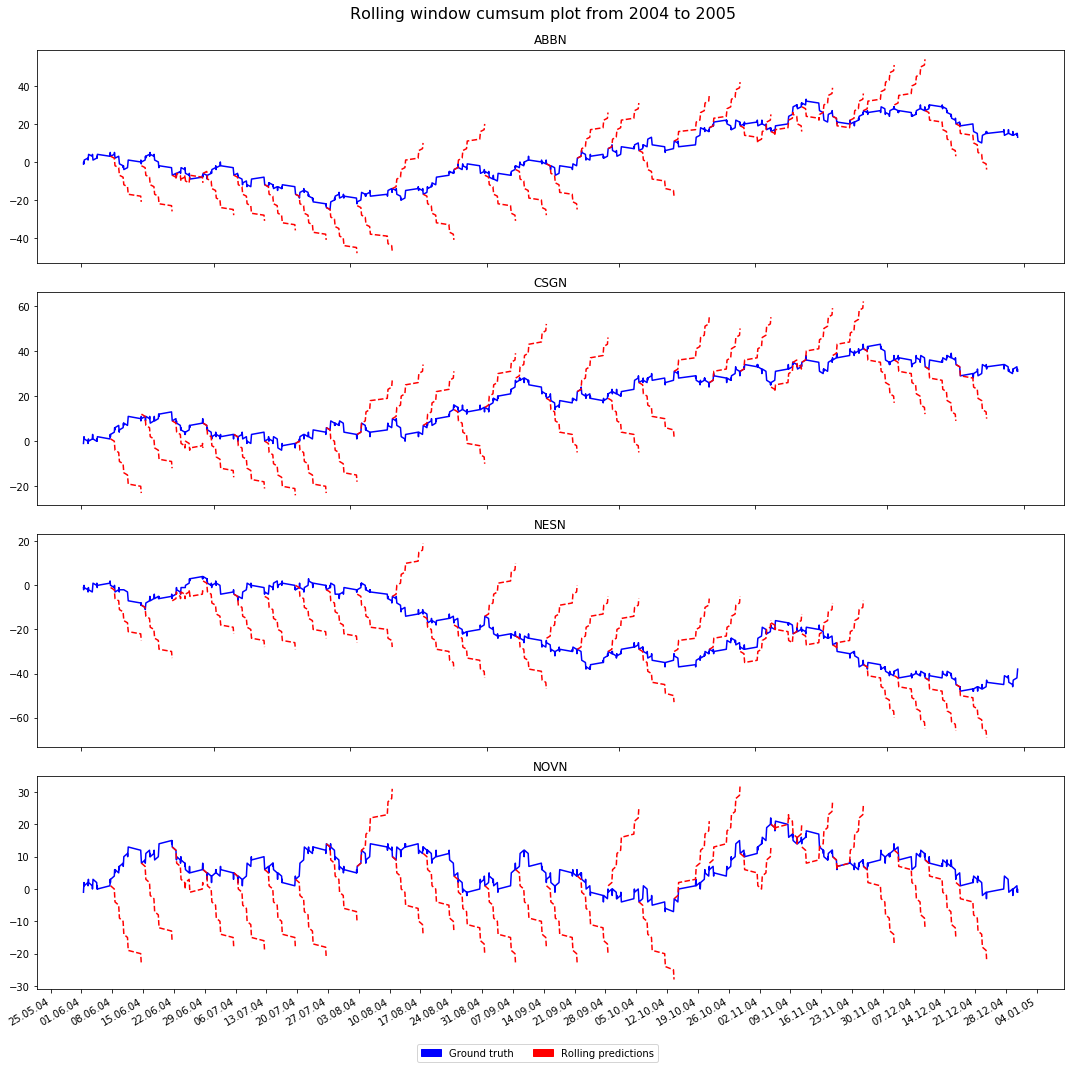

In [56]:
plot_rolling_window(df_sign, 2004)

### 4.1 2008-2009

Total samples: 1240
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

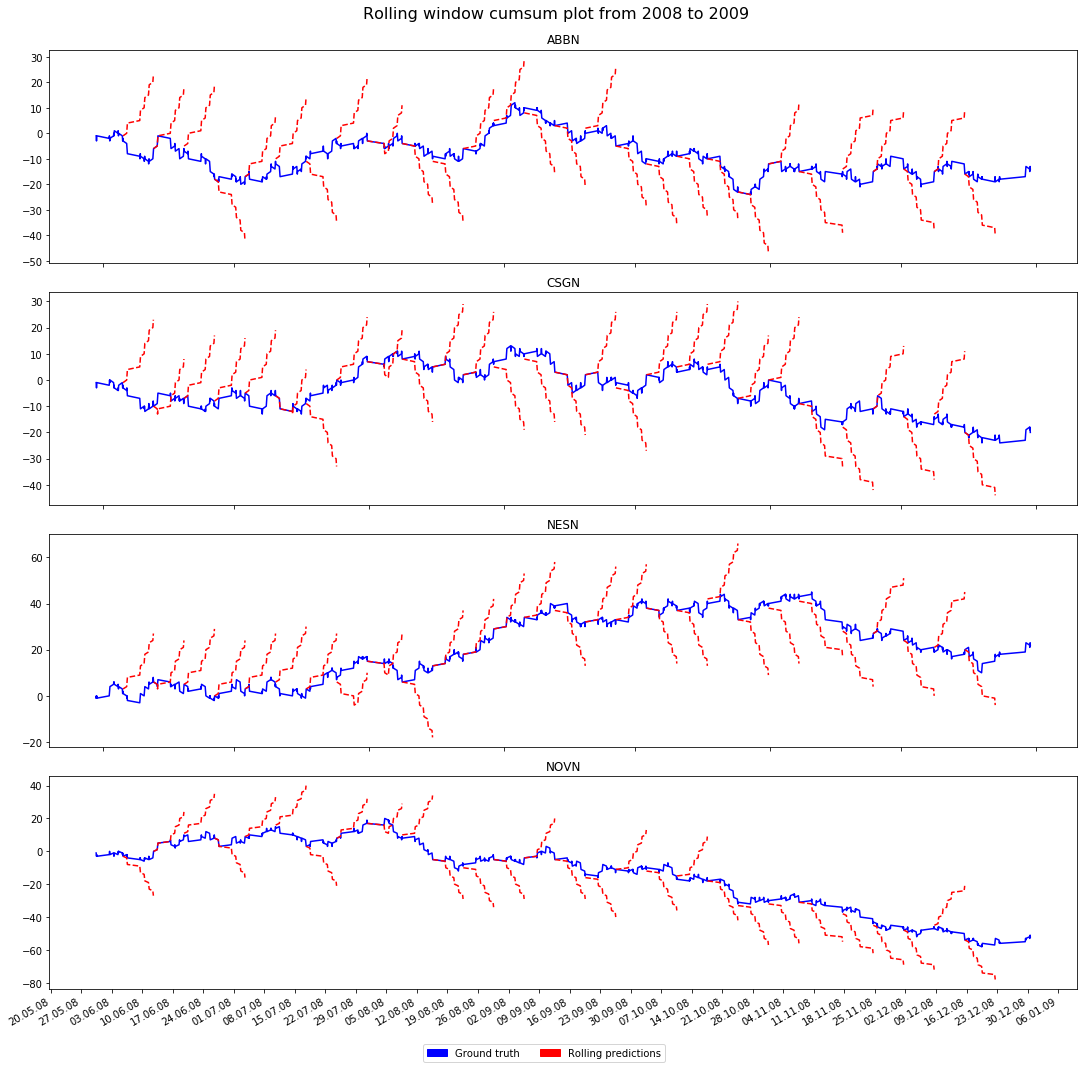

In [57]:
plot_rolling_window(df_sign, 2008)

### 4.1 2012-2013

Total samples: 1245
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

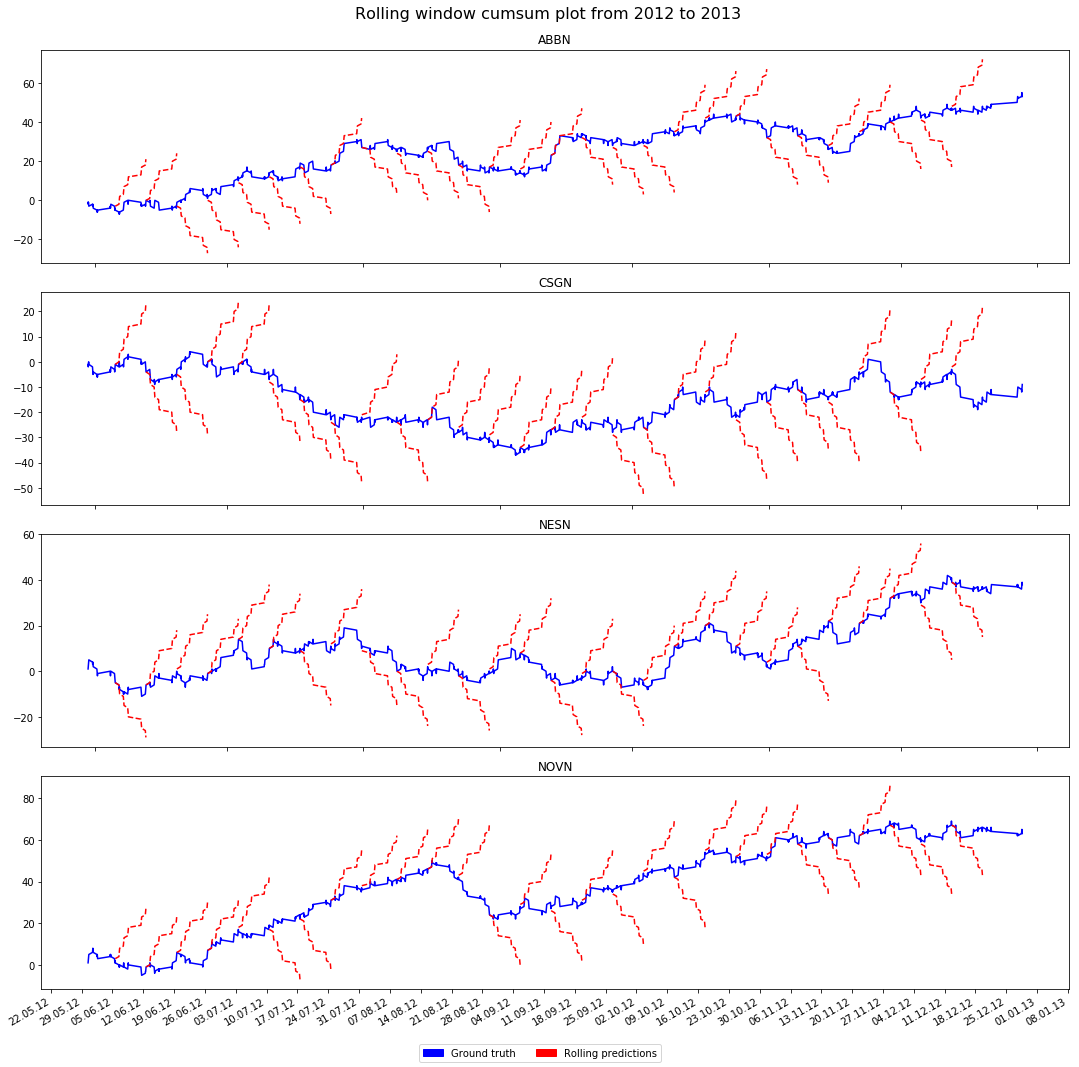

In [58]:
plot_rolling_window(df_sign, 2012)

### 4.1 2016-2017

Total samples: 1270
Window incides -> Train: 0-500, Test: 500-550
Window incides -> Train: 25-525, Test: 525-575
Window incides -> Train: 50-550, Test: 550-600
Window incides -> Train: 75-575, Test: 575-625
Window incides -> Train: 100-600, Test: 600-650
Window incides -> Train: 125-625, Test: 625-675
Window incides -> Train: 150-650, Test: 650-700
Window incides -> Train: 175-675, Test: 675-725
Window incides -> Train: 200-700, Test: 700-750
Window incides -> Train: 225-725, Test: 725-775
Window incides -> Train: 250-750, Test: 750-800
Window incides -> Train: 275-775, Test: 775-825
Window incides -> Train: 300-800, Test: 800-850
Window incides -> Train: 325-825, Test: 825-875
Window incides -> Train: 350-850, Test: 850-900
Window incides -> Train: 375-875, Test: 875-925
Window incides -> Train: 400-900, Test: 900-950
Window incides -> Train: 425-925, Test: 925-975
Window incides -> Train: 450-950, Test: 950-1000
Window incides -> Train: 475-975, Test: 975-1025
Window incides -> Train

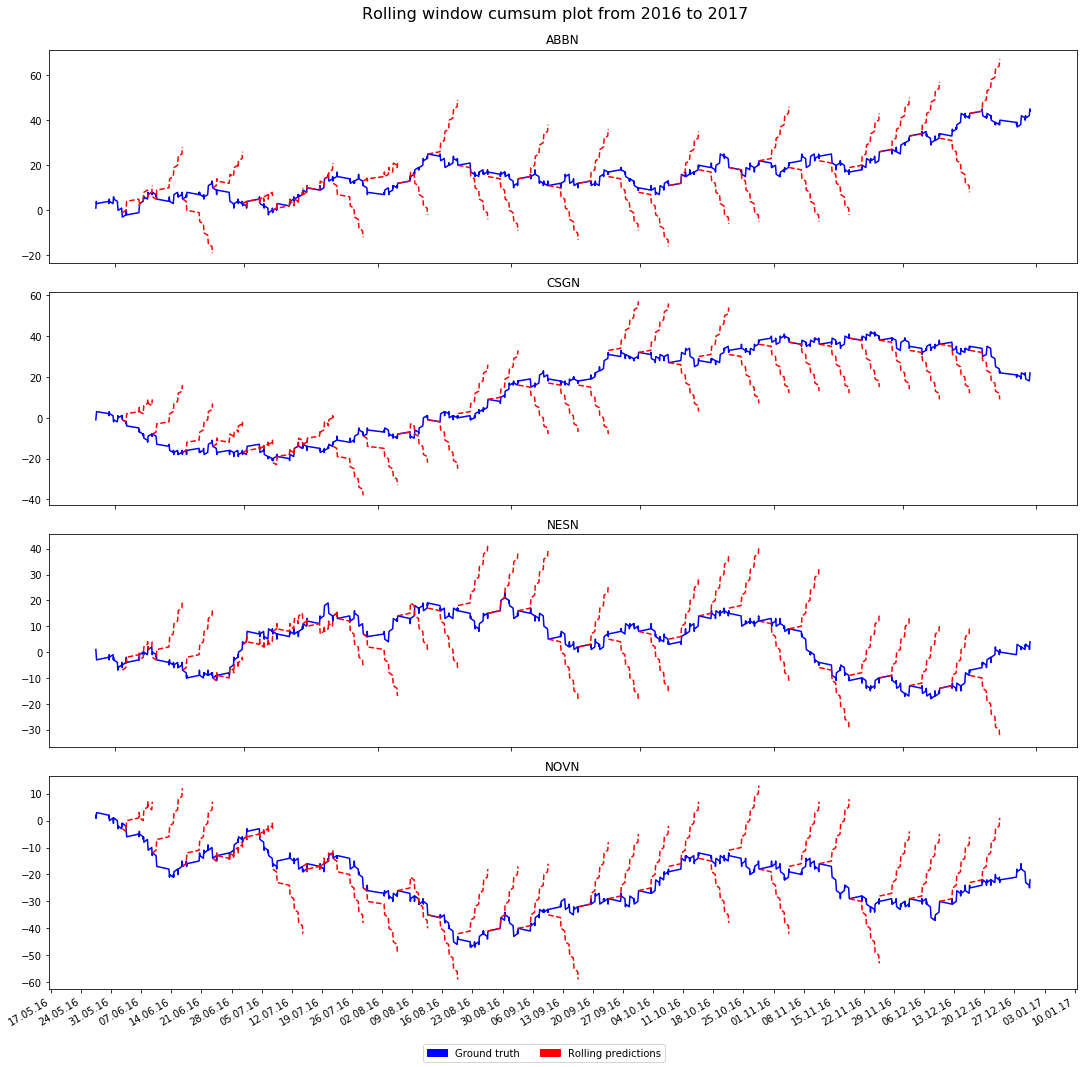

In [59]:
plot_rolling_window(df_sign, 2016)

An analysis of the above plots is found in our report.

## 5 Evaluation

To evaluate if our network actually has some forecasting abilities, we decided to test it in the following way:

- For each week we predict if the price is going up or down, by observing if the cumulative sum after 25 datapoints is greater or lower than zero.
- This prediction will be the position that we then take by virtually investing in the stock.
    - If our prediction says the stock will go up, we invest in it for one week
    - If our prediction says the stock will go down, we short the stock for one week
- After this week we sell and aggregate the gained or lost money from all four stocks. We calculate each return by simply taking the differences between the following week's price and the current one.
- We again invest the same money for the next week and repeat the process, keeping track of our gained and lost money total.

### 5.1 Getting Yahoo Data

We load the daily adjusted close prices of the four assets that we used from Yahoo Finance.

**Warning**: The Yahoo Finance API is deprecated and using the Pandas Datareader can sometimes result in corrupt data being requested.
We already saved the Yahoo dataframe under yahoo.csv.gz, which can be loaded in the next section.

In [30]:
stocks = ['ABBN','CSGN','NESN','NOVN']
stocks_yahoo = ['ABBN.VX','CSGN.VX','NESN.VX','NOVN.VX']
stocks_pred = ['ABBN_pred', 'CSGN_pred', 'NESN_pred', 'NOVN_pred']

In [31]:
start_date = '2000-01-01'
end_date = '2017-01-01'

for stock in stocks_yahoo:
    if stock == 'ABBN.VX':
        data_yahoo = data.DataReader(stock, 'yahoo', start_date, end_date)
        data_yahoo = data_yahoo.drop(columns=['High','Low','Open','Close','Volume'])
        data_yahoo = data_yahoo.rename(columns={'Adj Close':stock})
    else:
        data_yahoo_temp = data.DataReader(stock, 'yahoo', start_date, end_date)
        data_yahoo[stock] = data_yahoo_temp['Adj Close']
data_yahoo.columns = stocks
data_yahoo.to_csv(os.path.join(DATA_CLEAN_DIR, 'yahoo.csv.gz'), compression='gzip')

Text(0.5, 1.0, 'Adjusted close')

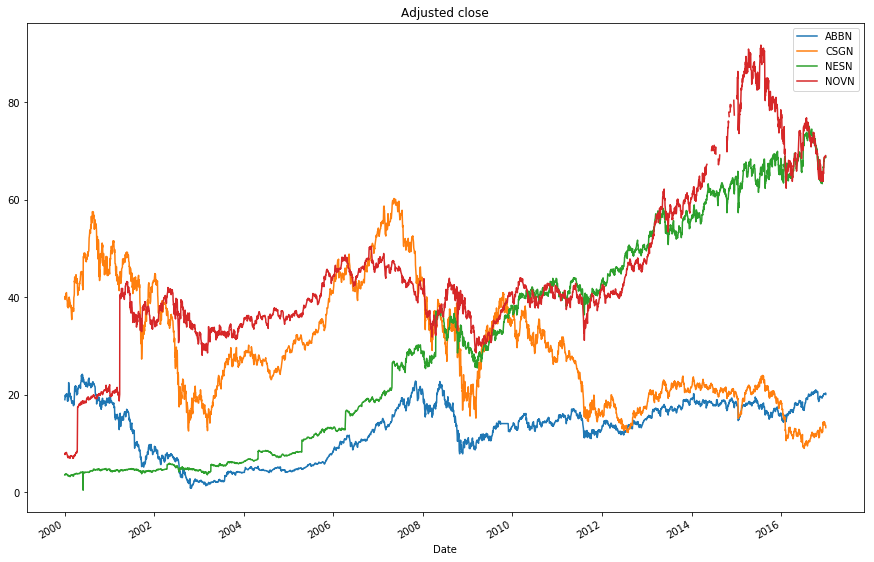

In [32]:
data_yahoo.plot(figsize=(15,10))
plt.title('Adjusted close')

### 5.2 Load Prediction and Yahoo Data

In [33]:
data_yahoo = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'yahoo.csv.gz'), compression='gzip', index_col='Date')
cumsum_preds_2004 = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'cumsum_preds_2004.csv.gz'), compression='gzip',index_col='Unnamed: 0')
cumsum_preds_2008 = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'cumsum_preds_2008.csv.gz'), compression='gzip',index_col='Unnamed: 0')
cumsum_preds_2012 = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'cumsum_preds_2012.csv.gz'), compression='gzip',index_col='Unnamed: 0')
cumsum_preds_2016 = pd.read_csv(os.path.join(DATA_CLEAN_DIR, 'cumsum_preds_2016.csv.gz'), compression='gzip',index_col='Unnamed: 0')

In [36]:
print('Gains in 2004:', evaluate(data_yahoo, cumsum_preds_2004))
print('Gains in 2008:', evaluate(data_yahoo, cumsum_preds_2008))
print('Gains in 2012:', evaluate(data_yahoo, cumsum_preds_2012))
print('Gains in 2016:', evaluate(data_yahoo, cumsum_preds_2016))

Gains in 2004: -7.867784023284912
Gains in 2008: -1.952231407165577
Gains in 2012: 8.426465988159203
Gains in 2016: 14.010805130004924


In 2004 and 2008, following the proposed positions of our network yielded a negative overall result. 
Even with the financial crisis in 2008, we did not loose all that much.
Even if after 2012, Deep Learning has gained traction and LSTMs have been used for financial forecasting, our network performed quite well.